# Classify high/low `mpg` cars in `Auto` dataset

## Prepare the dataset

In [1]:
import pandas as pd

auto = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Auto.csv')

In [3]:
### 
## impute missing horsepower values with mean
#

# replace `?` with 0 so means can be calculated
for index in auto.index:
    if auto.loc[index, 'horsepower'] == '?':
        auto.loc[index, 'horsepower'] = 0

# cast horsepower to numeric dtype
auto.loc[ : , 'horsepower'] = pd.to_numeric(auto.horsepower)

# now impute values
for index in auto.index:
    if auto.loc[index, 'horsepower'] == 0:
        auto.loc[index, 'horsepower'] = auto[auto.cylinders == auto.loc[index, 'cylinders']].horsepower.mean()

## (a) Create high and low mpg classes

In [22]:
# represent high mpg as mpg above the median
auto['mpg01'] = (auto.mpg > auto.mpg.median()).astype('int32')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0


In [129]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 10 columns):
mpg             397 non-null float64
cylinders       397 non-null int64
displacement    397 non-null float64
horsepower      397 non-null float64
weight          397 non-null int64
acceleration    397 non-null float64
year            397 non-null int64
origin          397 non-null int64
name            397 non-null object
mpg01           397 non-null int32
dtypes: float64(4), int32(1), int64(4), object(1)
memory usage: 29.5+ KB


Note high `mpg` is represented by class 1

## (b) Visual feature selection

In [24]:
import seaborn as sns
sns.set_style('white')

import warnings  
warnings.filterwarnings('ignore')

### Quantitative features

We'll inspect some plots of the quantitative variables against the high/low classes first.

Of course, `mpg` will completely separate classes, which is unsurprising. We won't use this feature in our models, since it seems like cheating and/or makes the exercise uninteresting.

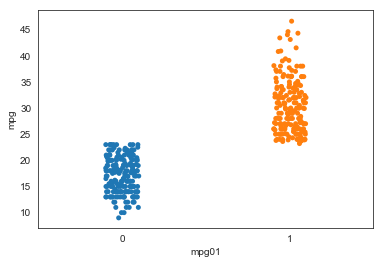

In [76]:
ax = sns.stripplot(x="mpg01", y="mpg", data=auto)

Now let's look at the other quanitative features

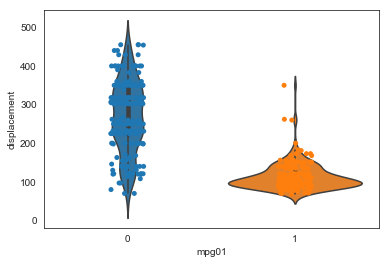

In [48]:
ax = sns.violinplot(x="mpg01", y="displacement", data=auto)
ax = sns.stripplot(x="mpg01", y="displacement", data=auto)

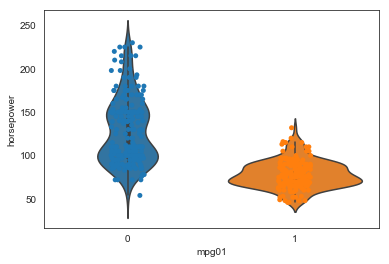

In [49]:
ax = sns.violinplot(x="mpg01", y="horsepower", data=auto)
ax = sns.stripplot(x="mpg01", y="horsepower", data=auto)

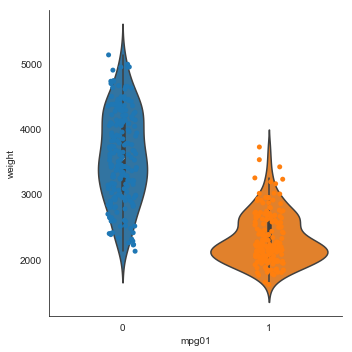

In [64]:
ax = sns.catplot(x="mpg01", y="weight", data=auto, kind='violin')
ax = sns.stripplot(x="mpg01", y="weight", data=auto)

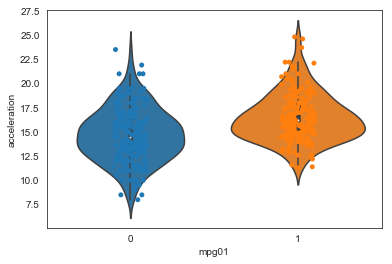

In [50]:
ax = sns.violinplot(x="mpg01", y="acceleration", data=auto)
ax = sns.stripplot(x="mpg01", y="acceleration", data=auto)

Since the number of unique values for `year` is small

In [82]:
auto.year.unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

one might argue it should be trasted as a qualitative variable. However, since there it has a natural (time) ordering we treat it as quantitative 

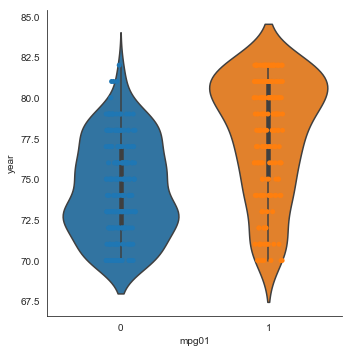

In [72]:
ax = sns.catplot(x="mpg01", y="year", data=auto, kind='violin')
ax = sns.stripplot(x="mpg01", y="year", data=auto)

With the exception of `acceleration` and possibly year, all these plots show a good separation of the distributions across the `mpg` classes. Based on these plots, all the quantitative variable except `acceleration` look like useful features for predicting `mpg` class.

### Qualitative features

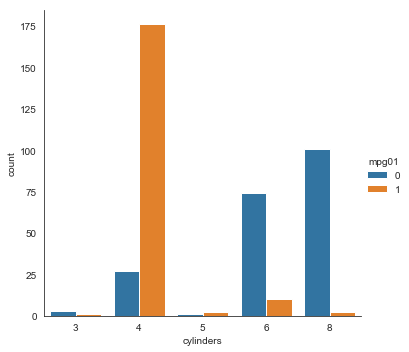

In [74]:
ax = sns.catplot(x="cylinders", hue='mpg01', data=auto, kind='count')

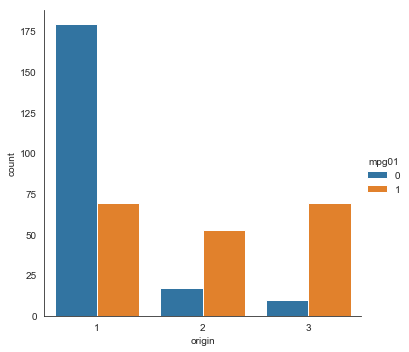

In [75]:
ax = sns.catplot(x="origin", hue='mpg01', data=auto, kind='count')

Since `cylinders` and `origin` separate the `mpg` classes well they both should be useful predictors. 

Note: we're going to ignore `name` for now. This is a categorical variable but it has a lot of levels

In [89]:
len(auto.name.unique())

304

and analysis is likely a bit complicated

## (c) Train-test split

In [83]:
import sklearn.model_selection as skl_model_selection
import statsmodels.api as sm

In [92]:
X, y = sm.add_constant(auto.drop(['acceleration', 'mpg01', 'name'], axis=1).values), auto.mpg01.values
X_train, X_test, y_train, y_test = skl_model_selection.train_test_split(X, y)

## (d) LDA model

In [99]:
import sklearn.discriminant_analysis as skl_discriminant_analysis

LDA_model = skl_discriminant_analysis.LinearDiscriminantAnalysis()

In [100]:
import sklearn.metrics as skl_metrics

skl_metrics.accuracy_score(y_test, LDA_model.fit(X_train, y_train).predict(X_test))

0.93

Impressive!

## (e) QDA model

In [101]:
QDA_model = skl_discriminant_analysis.QuadraticDiscriminantAnalysis()

In [102]:
skl_metrics.accuracy_score(y_test, QDA_model.fit(X_train, y_train).predict(X_test))

0.48

Much worse :(

### (f) Logit model

In [104]:
import sklearn.linear_model as skl_linear_model

Logit_model = skl_linear_model.LogisticRegression()

In [105]:
skl_metrics.accuracy_score(y_test, Logit_model.fit(X_train, y_train).predict(X_test))

0.94

Better!

### (g) KNN model

In [106]:
import sklearn.neighbors as skl_neighbors

In [109]:
models = {}
accuracies = {}

for i in range(1, 11):
    name = 'KNN' + str(i)
    models[name] = skl_neighbors.KNeighborsClassifier(n_neighbors=i)
    accuracies[name] = skl_metrics.accuracy_score(y_test, models[name].fit(X_train, y_train).predict(X_test))

In [126]:
pd.DataFrame(accuracies, index=[0]).sort_values(by=[0], axis='columns', ascending=False)

,KNN5,KNN9,KNN10,KNN3,KNN7,KNN1,KNN6,KNN8,KNN4,KNN2
0,0.83,0.83,0.83,0.82,0.82,0.8,0.8,0.8,0.76,0.7


These values are all really close, except perhaps $N=2,4$. Given the bias-variance tradeoff, we'd probably want to select $N=3$ or $N=5$ based on these results

## Bonus: Performance Improvement

### Feature Selection

### Interactions

In this section, we`ll use EDA to determine significant interactions. Specifically, we'll use one or more of

- graphical methods 
- ANOVA
- $\chi^2$ test for independence

### Transformations